**==== 1 - Data import and pre-processing ====**

In [1]:
# dwonload and unzip dataset
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip
!unzip /content/complaints.csv.zip -d /content/complaints.csv
# install NLTK
!pip install nltk

--2022-05-28 05:42:53--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 18.67.76.96, 18.67.76.30, 18.67.76.63, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|18.67.76.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443784008 (423M) [binary/octet-stream]
Saving to: ‘complaints.csv.zip’

complaints.csv.zip  100%[===================>] 423.22M   172MB/s    in 2.5s    

2022-05-28 05:42:56 (172 MB/s) - ‘complaints.csv.zip’ saved [443784008/443784008]

Archive:  /content/complaints.csv.zip
  inflating: /content/complaints.csv/complaints.csv  
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO

from nltk.stem.snowball import SnowballStemmer

from IPython.display import display

In [3]:
# load data into a pandas dataframe from csv file
df = pd.read_csv("/content/complaints.csv/complaints.csv",low_memory=False)
df.shape

(2693834, 18)

In [4]:
# seperate Product & Consumer Complaints columns from initial dataframe
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [5]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1119247
Debt collection                                                                  425150
Mortgage                                                                         354535
Credit card or prepaid card                                                      145184
Credit reporting                                                                 140430
Checking or savings account                                                      123369
Credit card                                                                       89190
Bank account or service                                                           86206
Student loan                                                                      67011
Money transfer, virtual currency, or money service                                40671
Vehicle loan or lease                                                             33068
Consumer Loan                   

In [6]:
# check null values on complaints
df.isnull().sum()

Product                               0
Consumer complaint narrative    1750971
dtype: int64

In [7]:
# keep only 'not null' complaints rows
df = df[pd.notnull(df['Consumer complaint narrative'])] 
df.shape

(942863, 2)

In [8]:
# since the dataset is imbalanced
# remove products with complaints < 10,000
# remove products with complaints > 100,000 
counts = df['Product'].value_counts()
df = df[~df['Product'].isin(counts[counts < 10000].index)]
df = df[~df['Product'].isin(counts[counts > 100000].index)]
df.shape

(357009, 2)

In [9]:
df['Product'].value_counts()

Mortgage                                              91969
Credit card or prepaid card                           71415
Checking or savings account                           45394
Credit reporting                                      31588
Student loan                                          30813
Money transfer, virtual currency, or money service    22485
Credit card                                           18838
Vehicle loan or lease                                 17640
Bank account or service                               14885
Payday loan, title loan, or personal loan             11982
Name: Product, dtype: int64

In [10]:
# remove duplicated rows in dataframe
df = df.drop_duplicates(keep="first")
df.shape

(353019, 2)

In [11]:
df['Product'].value_counts()

Mortgage                                              91837
Credit card or prepaid card                           70241
Checking or savings account                           45341
Student loan                                          30670
Credit reporting                                      29827
Money transfer, virtual currency, or money service    22199
Credit card                                           18757
Vehicle loan or lease                                 17357
Bank account or service                               14856
Payday loan, title loan, or personal loan             11934
Name: Product, dtype: int64

In [12]:
# overwrite colum names into 'Product' & 'Consumer_Complaint'
df.columns = ['Product', 'Consumer_Complaint']
df

,Product,Consumer_Complaint
54,Credit card or prepaid card,"Please reopen case XXXX, Nothing has been reso..."
108,Credit card or prepaid card,This was not sent is error i am a consumer by ...
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...
138,Vehicle loan or lease,Sun coast credit union committed insurance fra...
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...
...,...,...
2693824,Credit card,A reward coupon from XXXX expired and American...
2693826,Credit reporting,Wrong name no XXXX XXXX XXXX and wrong address...
2693828,Credit card,"Automated calls from "" XXXX with Capital One '..."
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...


In [13]:
# convert complaints data into lowercase
# tf-idf cares very much whether words are capitalized or not. 
# They're different words as far as the algorithm can tell. This is why normalization (lower-casing in this case) is so important.
# df["Consumer_Complaint"] = df["Consumer_Complaint"].str.lower()
# df

In [ ]:
np.random.seed(10)
remove_n = 200000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)
df.shape

In [14]:
# manually add specific id to each product type
# cid={'Credit reporting':0, 'Student loan':1, 'Mortgage':2, 'Debt collection':3, 'Vehicle loan or lease':4, 'Credit card or prepaid card':5, 'Checking or savings account':6, 'Money transfer, virtual currency, or money service':7, 'Credit card':8, 'Payday loan, title loan, or personal loan':9, 'Bank account or service':10}
# df['cid']=df['Product'].map(cid)
df['cid'] = df['Product'].factorize()[0]
df

,Product,Consumer_Complaint,cid
54,Credit card or prepaid card,"Please reopen case XXXX, Nothing has been reso...",0
108,Credit card or prepaid card,This was not sent is error i am a consumer by ...,0
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...,0
138,Vehicle loan or lease,Sun coast credit union committed insurance fra...,1
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,1
...,...,...,...
2693824,Credit card,A reward coupon from XXXX expired and American...,9
2693826,Credit reporting,Wrong name no XXXX XXXX XXXX and wrong address...,7
2693828,Credit card,"Automated calls from "" XXXX with Capital One '...",9
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...,5


In [15]:
df['Product'].value_counts()

Mortgage                                              91837
Credit card or prepaid card                           70241
Checking or savings account                           45341
Student loan                                          30670
Credit reporting                                      29827
Money transfer, virtual currency, or money service    22199
Credit card                                           18757
Vehicle loan or lease                                 17357
Bank account or service                               14856
Payday loan, title loan, or personal loan             11934
Name: Product, dtype: int64

In [16]:
# Text Preprocessing using NLTK
# function definition for stemming, tokenizing, removing stop words and 'XX' values from complaint strings using NLTK
# this will be used on TfidfVectorizer
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
def wordTokenizer(text):
   # tokenize words using nltk word_tokenize operation and remove unnecessary characters
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   # convert complaints data into lowercase
   # tf-idf consider same word in different case (lowercase/uppercase/camelcase/mixed) formats as different words. 
   tokens = map(str.lower, tokens)
   # stem and return tokens that are not in stop words list
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


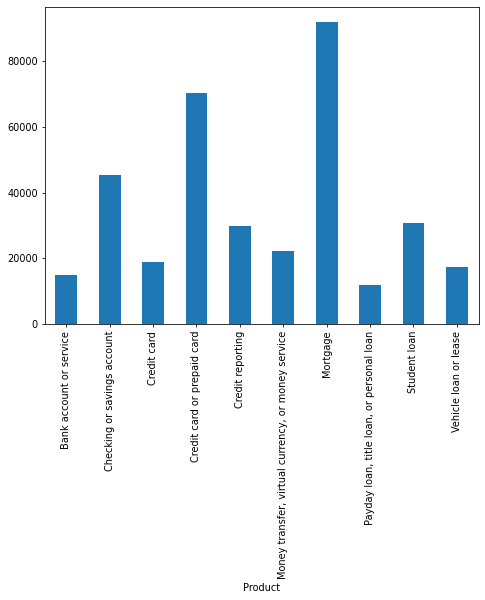

In [17]:
# data distribution among selected product classes
fig = plt.figure(figsize=(8,6),dpi=70.0)
df.groupby('Product').Consumer_Complaint.count().plot.bar(ylim=0)
plt.show()

==== 2. Creating Feature Vector ====

In [18]:
# dataframe to map product - category_id 
category_id_df = df[['Product', 'cid']].drop_duplicates().sort_values('cid')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['cid', 'Product']].values)

In [19]:
nltk.download('punkt')
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.75, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=None, lowercase=False, max_features=1000, tokenizer=wordTokenizer)
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=None, lowercase=False, max_features=1000, tokenizer=wordTokenizer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
features = tfidf.fit_transform(df.Consumer_Complaint).toarray()
labels = df.cid
features.shape

In [ ]:
N = 2
for Product, cid in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == cid)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [item for item in feature_names if len(item.split(' ')) == 1]
  bigrams = [item for item in feature_names if len(item.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

**==== 3. Train, Test and Compare Different ML Models ====**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_Complaint'], df['Product'], random_state = 0, test_size=0.2)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(max_iter=2000),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

**==== 4. Result Discussion ====**

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in category_id_df.cid:
  for actual in category_id_df.cid:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_Complaint']])
      print('')

In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))